In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy import stats
import pandas as pd
from scipy import optimize
# from tqdm import tqdm
from scipy.special import factorial2
from scipy import special
from scipy.integrate import quad
import random
from tqdm import tqdm
import warnings
import statsmodels.formula.api as smf
from scipy import interpolate
warnings.filterwarnings('ignore')

In [2]:
import scienceplots 
plt.style.use(['science','no-latex'])

## import data

In [3]:
option = pd.read_csv('beta00_alpha10/filtered_SSE50Option.csv')
option = option[option.Vega != 0]
option['mnes'] = option['StrikePrice']/option['close']
option['days'] = np.rint(option['TTM']*365)
option['RisklessRate'] = option['RisklessRate']/100
print(option.shape[0])
option.head()

18351


,Unnamed: 0,date,TTM,StrikePrice,close,mid_price,Vega,ImpliedVolatility,RisklessRate,mnes,days
0,0,2015-02-11,0.364384,2.45,2.38,0.1358,0.577,0.2726,0.0275,1.029412,133.0
1,1,2015-02-11,0.613699,2.45,2.38,0.1925,0.746,0.2767,0.0275,1.029412,224.0
2,2,2015-02-11,0.115068,2.20,2.38,0.2107,0.205,0.2817,0.0275,0.924370,42.0
3,3,2015-02-11,0.115068,2.25,2.38,0.1702,0.248,0.2704,0.0275,0.945378,42.0
4,4,2015-02-11,0.115068,2.30,2.38,0.1363,0.289,0.2711,0.0275,0.966387,42.0


In [12]:
## 用RV 定义高低波动
prc = pd.read_csv('Other empirics/SSE RV.csv')
prc.RV = prc.RV/100
prc.Trddt = pd.to_datetime(prc['Trddt'], format='%Y/%m/%d').dt.strftime('%Y-%m-%d')
prc = prc.rename(columns={"Trddt": "Date"})
prc = prc.dropna(subset=['RV'])
prc = prc[prc.Date>'2015-02-01']
prc = prc[prc.Date<'2022-12-31']

RV = prc.copy()
RVS = RV[RV.RV<RV.RV.median()]
RVL = RV[RV.RV>RV.RV.median()]

## model-based IV

In [13]:
DN05 = pd.read_csv('beta00_alpha05/fitted_value_05.csv')
DN05 = np.array(DN05.model_price)
DN10 = pd.read_csv('beta00_alpha10/fitted_value_10.csv')
DN10 = np.array(DN10.model_price)
DN0505 = pd.read_csv('beta00_alpha0505/fitted_value_0505.csv')
DN0505 = np.array(DN0505.model_price)
DN1010 = pd.read_csv('beta00_alpha1010/fitted_value_1010.csv')
DN1010 = np.array(DN1010.model_price) 

In [14]:
option['DN05_prc'] = DN05
option['DN10_prc'] = DN10
option['DN0505_prc'] = DN0505
option['DN1010_prc'] = DN1010

In [15]:
import scipy.optimize as optimize
import math
from scipy.stats import norm

# Black-Scholes 定价公式（考虑连续分红率）
def black_scholes_call(S, K, T, r, q, sigma):
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    call_price = S * math.exp(-q * T) * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    return call_price

# 计算隐含波动率的函数（考虑连续分红率）
# def implied_volatility(S, K, T, r, q, market_price, option_type='call'):
#     # 定义误差函数
#     def objective_function(sigma):
#         if option_type == 'call':
#             return black_scholes_call(S, K, T, r, q, sigma) - market_price
#         else:
#             raise NotImplementedError("仅支持看涨期权")
    
#     # 使用优化器找到隐含波动率
#     result = optimize.root_scalar(objective_function, bracket=[0.0001, 1.2], method='brentq')
    
#     return result.root if result.converged else None
def implied_volatility(S, K, T, r, q, market_price, tol=1e-6, max_iterations=1000):
    # 设置初始区间
    lower_bound = 0.0001
    upper_bound = 5.0
    iteration = 0
    mid_vol = (lower_bound + upper_bound) / 2.0

    # 二分法迭代
    while iteration < max_iterations:
        mid_vol = (lower_bound + upper_bound) / 2.0
        price = black_scholes_call(S, K, T, r, q, mid_vol)
        
        # 误差达到容差范围时停止
        if abs(price - market_price) < tol:
            return mid_vol
        
        # 调整区间
        if price > market_price:
            upper_bound = mid_vol
        else:
            lower_bound = mid_vol
        
        iteration += 1

    # 如果达到最大迭代次数仍未收敛，返回 None
    return mid_vol if abs(price - market_price) < tol else None


# 示例使用
S = 100  # 标的资产价格
K = 100  # 执行价格
T = 1    # 距离到期时间（按年计算）
r = 0.05 # 无风险利率
q = 0.02 # 连续分红率
market_price = 10  # 市场期权价格

iv = implied_volatility(S, K, T, r, q, market_price)
print(f"隐含波动率: {iv:.4f}")

隐含波动率: 0.2204


In [16]:
%%time
option['DN05_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN05_prc']),axis=1)
option['DN10_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN10_prc']),axis=1)
option['DN0505_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN0505_prc']),axis=1)
option['DN1010_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN1010_prc']),axis=1)
option['market_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['mid_price']),axis=1)

CPU times: user 3min 46s, sys: 140 ms, total: 3min 46s
Wall time: 3min 46s


## level and slope

In [18]:
option['days'] = np.rint(option['TTM']*365)
option['log_mnes'] = np.log(option['StrikePrice']/option['close'])
option['log_mnes_norm'] = np.log(option['StrikePrice']*np.exp(-option['RisklessRate']*option['TTM'])/option['close'])/np.sqrt(option['TTM'])
option.head()

,Unnamed: 0,date,TTM,StrikePrice,close,mid_price,Vega,ImpliedVolatility,RisklessRate,mnes,...,DN10_prc,DN0505_prc,DN1010_prc,DN05_iv,DN10_iv,DN0505_iv,DN1010_iv,market_iv,log_mnes,log_mnes_norm
0,0,2015-02-11,0.364384,2.45,2.38,0.1358,0.577,0.2726,0.0275,1.029412,...,0.140260,0.137575,0.136389,0.277664,0.280360,0.275673,0.273604,0.272574,0.028988,0.031421
1,1,2015-02-11,0.613699,2.45,2.38,0.1925,0.746,0.2767,0.0275,1.029412,...,0.187256,0.190405,0.189864,0.275261,0.269663,0.273902,0.273172,0.276722,0.028988,0.015460
2,2,2015-02-11,0.115068,2.20,2.38,0.2107,0.205,0.2817,0.0275,0.924370,...,0.209595,0.206239,0.205531,0.262136,0.276593,0.260324,0.256786,0.281791,-0.078643,-0.241165
3,3,2015-02-11,0.115068,2.25,2.38,0.1702,0.248,0.2704,0.0275,0.945378,...,0.172571,0.168231,0.167498,0.265025,0.279740,0.262632,0.259694,0.270452,-0.056170,-0.174916
4,4,2015-02-11,0.115068,2.30,2.38,0.1363,0.289,0.2711,0.0275,0.966387,...,0.139214,0.134616,0.133979,0.267467,0.281142,0.265350,0.263147,0.271148,-0.034191,-0.110123


In [19]:
# option_ = option[(option.mnes>0.85)&(option.mnes<1.15)]
option_ = option.copy()

In [20]:
%%time
years = ['2015','2016','2017','2018','2019','2020','2021','2022']
dateList = np.unique(option.date)
level = np.array([])
slope = np.array([])

for i in tqdm(range(len(years))):
    year_ = years[i]
    tmp = dateList[dateList<=year_+'-12-31']
    tmp = tmp[tmp>str(int(year_)-1)+'-12-31']
    level_by_day = []
    slope_by_day = []
    level_by_day_norm = []
    slope_by_day_norm = []
    for j in range(len(tmp)):
        date0 = tmp[j]
        df0 = option_[option_.date==date0]
        df0 = df0[df0.ImpliedVolatility>0.05]
        
        model = smf.ols('market_iv~log_mnes', df0).fit()
        level_by_day.append(model.params[0])
        slope_by_day.append(model.params[1])
        
    level = np.concatenate([level, level_by_day])
    slope = np.concatenate([slope, slope_by_day])

print(np.corrcoef(level,slope)[0,1])    
level = pd.DataFrame(level, index=dateList)
slope = pd.DataFrame(slope, index=dateList)

100% 8/8 [00:01<00:00,  4.67it/s]

-0.1364227329209758
CPU times: user 1.74 s, sys: 10.3 ms, total: 1.75 s
Wall time: 1.73 s


In [21]:
%%time
years = ['2015','2016','2017','2018','2019','2020','2021','2022']
dateList = np.unique(option.date)
level_05 = np.array([])
slope_05 = np.array([])

for i in tqdm(range(len(years))):
    year_ = years[i]
    tmp = dateList[dateList<=year_+'-12-31']
    tmp = tmp[tmp>str(int(year_)-1)+'-12-31']
    level_by_day = []
    slope_by_day = []
    level_by_day_norm = []
    slope_by_day_norm = []
    for j in range(len(tmp)):
        date0 = tmp[j]
        df0 = option_[option_.date==date0]
        df0 = df0[df0.ImpliedVolatility>0.05]
        
        model = smf.ols('DN05_iv~log_mnes', df0).fit()
        level_by_day.append(model.params[0])
        slope_by_day.append(model.params[1])
        
    level_05 = np.concatenate([level_05, level_by_day])
    slope_05 = np.concatenate([slope_05, slope_by_day])

print(np.corrcoef(level_05,slope_05)[0,1])    
level_05 = pd.DataFrame(level_05, index=dateList)
slope_05 = pd.DataFrame(slope_05, index=dateList)

100% 8/8 [00:01<00:00,  4.72it/s]

0.07713982926715861
CPU times: user 1.71 s, sys: 5.15 ms, total: 1.71 s
Wall time: 1.7 s


In [22]:
%%time
years = ['2015','2016','2017','2018','2019','2020','2021','2022']
dateList = np.unique(option.date)
level_10 = np.array([])
slope_10 = np.array([])

for i in tqdm(range(len(years))):
    year_ = years[i]
    tmp = dateList[dateList<=year_+'-12-31']
    tmp = tmp[tmp>str(int(year_)-1)+'-12-31']
    level_by_day = []
    slope_by_day = []
    level_by_day_norm = []
    slope_by_day_norm = []
    for j in range(len(tmp)):
        date0 = tmp[j]
        df0 = option_[option_.date==date0]
        df0 = df0[df0.ImpliedVolatility>0.05]
        
        model = smf.ols('DN10_iv~log_mnes', df0).fit()
        level_by_day.append(model.params[0])
        slope_by_day.append(model.params[1])
        
    level_10 = np.concatenate([level_10, level_by_day])
    slope_10 = np.concatenate([slope_10, slope_by_day])

print(np.corrcoef(level_10,slope_10)[0,1])    
level_10 = pd.DataFrame(level_10, index=dateList)
slope_10 = pd.DataFrame(slope_10, index=dateList)

100% 8/8 [00:01<00:00,  4.70it/s]

0.12840903488311034
CPU times: user 1.72 s, sys: 7.22 ms, total: 1.73 s
Wall time: 1.71 s


In [23]:
%%time
years = ['2015','2016','2017','2018','2019','2020','2021','2022']
dateList = np.unique(option.date)
level_0505 = np.array([])
slope_0505 = np.array([])

for i in tqdm(range(len(years))):
    year_ = years[i]
    tmp = dateList[dateList<=year_+'-12-31']
    tmp = tmp[tmp>str(int(year_)-1)+'-12-31']
    level_by_day = []
    slope_by_day = []
    level_by_day_norm = []
    slope_by_day_norm = []
    for j in range(len(tmp)):
        date0 = tmp[j]
        df0 = option_[option_.date==date0]
        df0 = df0[df0.ImpliedVolatility>0.05]
        
        model = smf.ols('DN0505_iv~log_mnes', df0).fit()
        level_by_day.append(model.params[0])
        slope_by_day.append(model.params[1])
        
    level_0505 = np.concatenate([level_0505, level_by_day])
    slope_0505 = np.concatenate([slope_0505, slope_by_day])

print(np.corrcoef(level_0505,slope_0505)[0,1])    
level_0505 = pd.DataFrame(level_0505, index=dateList)
slope_0505 = pd.DataFrame(slope_0505, index=dateList)

100% 8/8 [00:01<00:00,  4.71it/s]

-0.14725258164932206
CPU times: user 1.72 s, sys: 5.14 ms, total: 1.73 s
Wall time: 1.71 s


In [24]:
%%time
years = ['2015','2016','2017','2018','2019','2020','2021','2022']
dateList = np.unique(option.date)
level_1010 = np.array([])
slope_1010 = np.array([])

for i in tqdm(range(len(years))):
    year_ = years[i]
    tmp = dateList[dateList<=year_+'-12-31']
    tmp = tmp[tmp>str(int(year_)-1)+'-12-31']
    level_by_day = []
    slope_by_day = []
    level_by_day_norm = []
    slope_by_day_norm = []
    for j in range(len(tmp)):
        date0 = tmp[j]
        df0 = option_[option_.date==date0]
        df0 = df0[df0.ImpliedVolatility>0.05]
        
        model = smf.ols('DN1010_iv~log_mnes', df0).fit()
        level_by_day.append(model.params[0])
        slope_by_day.append(model.params[1])
        
    level_1010 = np.concatenate([level_1010, level_by_day])
    slope_1010 = np.concatenate([slope_1010, slope_by_day])

print(np.corrcoef(level_1010,slope_1010)[0,1])    
level_1010 = pd.DataFrame(level_1010, index=dateList)
slope_1010 = pd.DataFrame(slope_1010, index=dateList)

100% 8/8 [00:01<00:00,  4.80it/s]

-0.040282673417128746
CPU times: user 1.69 s, sys: 7.33 ms, total: 1.7 s
Wall time: 1.67 s


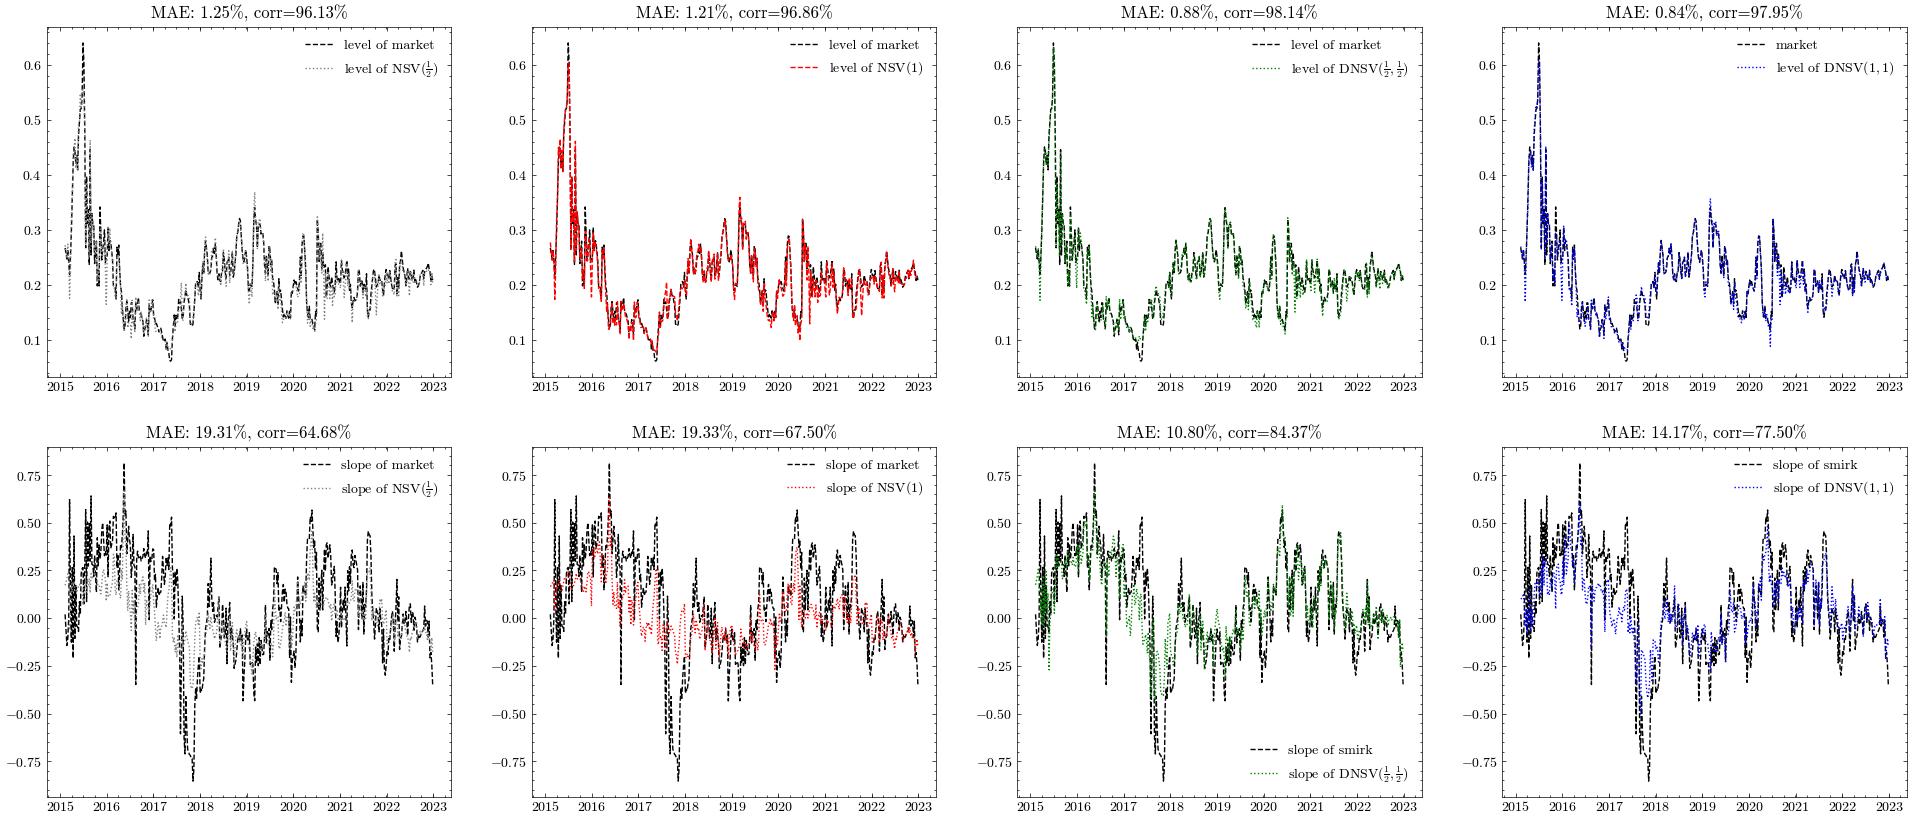

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(24,10))
x_date = pd.to_datetime(dateList)

ax[0][0].plot(x_date, level.values.reshape(-1), label='level of market',color='black',linestyle='--')
ax[0][0].plot(x_date, level_05.values.reshape(-1), label='level of NSV($\\frac{1}{2}$)',color='gray',linestyle='dotted')
ax[0][0].set_title('MAE: 1.25%, corr=96.13%')
ax[0][0].legend(framealpha=1)

ax[0][1].plot(x_date, level.values.reshape(-1), label='level of market',color='black',linestyle='--')
ax[0][1].plot(x_date, level_10.values.reshape(-1), label='level of NSV($1$)',color='red',linestyle='--')
ax[0][1].set_title('MAE: 1.21%, corr=96.86%')
ax[0][1].legend(framealpha=1)

ax[0][2].plot(x_date, level.values.reshape(-1), label='level of market',color='black',linestyle='--')
ax[0][2].plot(x_date, level_0505.values.reshape(-1), label='level of DNSV($\\frac{1}{2},\\frac{1}{2}$)',color='green',linestyle='dotted')
ax[0][2].set_title('MAE: 0.88%, corr=98.14%')
ax[0][2].legend(framealpha=1)

ax[0][3].plot(x_date, level.values.reshape(-1), label='market',color='black',linestyle='--')
ax[0][3].plot(x_date, level_1010.values.reshape(-1), label='level of DNSV($1,1$)',color='blue',linestyle='dotted')
ax[0][3].set_title('MAE: 0.84%, corr=97.95%')
ax[0][3].legend(framealpha=1)

x_date = pd.to_datetime(slope.index)

ax[1][0].plot(x_date, slope.values.reshape(-1), label='slope of market',color='black',linestyle='--')
ax[1][0].plot(x_date, slope_05.values.reshape(-1), label='slope of NSV($\\frac{1}{2}$)',color='gray',linestyle='dotted')
ax[1][0].set_title('MAE: 19.31%, corr=64.68%')
ax[1][0].legend(framealpha=1)

ax[1][1].plot(x_date, slope.values.reshape(-1), label='slope of market',color='black',linestyle='--')
ax[1][1].plot(x_date, slope_10.values.reshape(-1), label='slope of NSV($1$)',color='red',linestyle='dotted')
ax[1][1].set_title('MAE: 19.33%, corr=67.50%')
ax[1][1].legend(framealpha=1)

ax[1][2].plot(x_date, slope.values.reshape(-1), label='slope of smirk', color='black',linestyle='--')
ax[1][2].plot(x_date, slope_0505.values.reshape(-1), label='slope of DNSV($\\frac{1}{2},\\frac{1}{2}$)', color='green',linestyle='dotted')
ax[1][2].set_title('MAE: 10.80%, corr=84.37%')
ax[1][2].legend(framealpha=1)

ax[1][3].plot(x_date, slope.values.reshape(-1), label='slope of smirk', color='black',linestyle='--')
ax[1][3].plot(x_date, slope_1010.values.reshape(-1), label='slope of DNSV($1,1$)', color='blue',linestyle='dotted')
ax[1][3].set_title('MAE: 14.17%, corr=77.50%')
ax[1][3].legend(framealpha=1)

plt.show()

In [26]:
print('mean of level')
print(np.mean(level.values.reshape(-1) - level_05.values.reshape(-1)))
print(np.mean(level.values.reshape(-1) - level_10.values.reshape(-1)))
print(np.mean(level.values.reshape(-1) - level_0505.values.reshape(-1)))
# print(np.mean(level.values.reshape(-1) - level_0510.values.reshape(-1)))
print(np.mean(level.values.reshape(-1) - level_1010.values.reshape(-1)))
print('mae of level')
print(np.mean(np.abs(level.values.reshape(-1) - level_05.values.reshape(-1))))
print(np.mean(np.abs(level.values.reshape(-1) - level_10.values.reshape(-1))))
print(np.mean(np.abs(level.values.reshape(-1) - level_0505.values.reshape(-1))))
# print(np.mean(np.abs(level.values.reshape(-1) - level_0510.values.reshape(-1))))
print(np.mean(np.abs(level.values.reshape(-1) - level_1010.values.reshape(-1))))
print('corr of level')
print(np.corrcoef(level.values.reshape(-1), level_05.values.reshape(-1))[0,1])
print(np.corrcoef(level.values.reshape(-1), level_10.values.reshape(-1))[0,1])
print(np.corrcoef(level.values.reshape(-1), level_0505.values.reshape(-1))[0,1])
# print(np.corrcoef(level.values.reshape(-1), level_0510.values.reshape(-1))[0,1])
print(np.corrcoef(level.values.reshape(-1), level_1010.values.reshape(-1))[0,1])

mean of level
0.0041925348075377
0.0037722811037062317
0.0020807209095970707
0.0021452227916162604
mae of level
0.009586984915286326
0.008415886497049125
0.006010198887274473
0.005472704807001515
corr of level
0.9835523058440585
0.9875205024902678
0.9917478785858496
0.9924519693598528


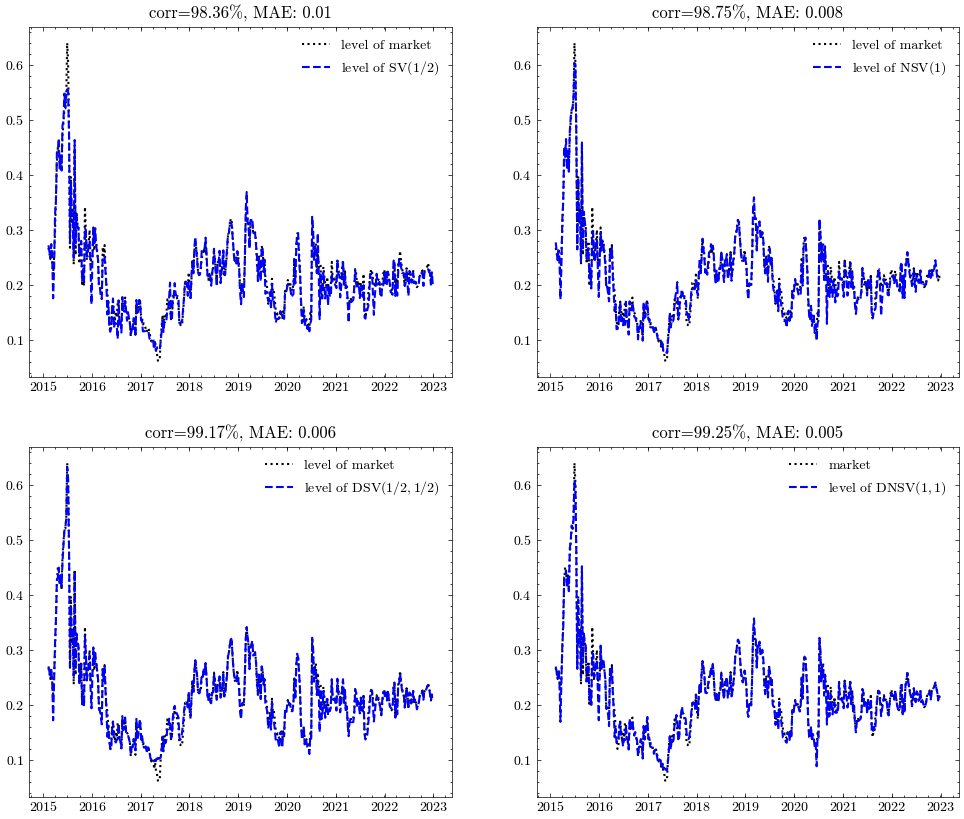

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
x_date = pd.to_datetime(dateList)

ax[0][0].plot(x_date, level.values.reshape(-1), label='level of market',color='black',linestyle='dotted',linewidth=1.5)
ax[0][0].plot(x_date, level_05.values.reshape(-1), label='level of SV($1/2$)',color='blue',linestyle='--',linewidth=1.5)
corr = np.round(np.corrcoef(level.values.reshape(-1), level_05.values.reshape(-1))[0,1]*100, 2)
mae  = np.round(np.mean(np.abs(level.values.reshape(-1) - level_05.values.reshape(-1))), 3)
ax[0][0].set_title('corr='+str(corr)+'%, MAE: '+str(mae))
ax[0][0].legend(framealpha=1)

ax[0][1].plot(x_date, level.values.reshape(-1), label='level of market',color='black',linestyle='dotted',linewidth=1.5)
ax[0][1].plot(x_date, level_10.values.reshape(-1), label='level of NSV($1$)',color='blue',linestyle='--',linewidth=1.5)
corr = np.round(np.corrcoef(level.values.reshape(-1), level_10.values.reshape(-1))[0,1]*100, 2)
mae  = np.round(np.mean(np.abs(level.values.reshape(-1) - level_10.values.reshape(-1))), 3)
ax[0][1].set_title('corr='+str(corr)+'%, MAE: '+str(mae))
ax[0][1].legend(framealpha=1)

ax[1][0].plot(x_date, level.values.reshape(-1), label='level of market',color='black',linestyle='dotted',linewidth=1.5)
ax[1][0].plot(x_date, level_0505.values.reshape(-1), label='level of DSV($1/2,1/2$)',color='blue',linestyle='--',linewidth=1.5)
corr = np.round(np.corrcoef(level.values.reshape(-1), level_0505.values.reshape(-1))[0,1]*100, 2)
mae  = np.round(np.mean(np.abs(level.values.reshape(-1) - level_0505.values.reshape(-1))), 3)
ax[1][0].set_title('corr='+str(corr)+'%, MAE: '+str(mae))
ax[1][0].legend(framealpha=1)

ax[1][1].plot(x_date, level.values.reshape(-1), label='market',color='black',linestyle='dotted',linewidth=1.5)
ax[1][1].plot(x_date, level_1010.values.reshape(-1), label='level of DNSV($1,1$)',color='blue',linestyle='--',linewidth=1.5)
corr = np.round(np.corrcoef(level.values.reshape(-1), level_1010.values.reshape(-1))[0,1]*100, 2)
mae  = np.round(np.mean(np.abs(level.values.reshape(-1) - level_1010.values.reshape(-1))), 3)
ax[1][1].set_title('corr='+str(corr)+'%, MAE: '+str(mae))
ax[1][1].legend(framealpha=1)

plt.savefig('fit_level.eps',dpi=400)
plt.show()

In [30]:
print('mean of slope')
print(np.mean(slope.values.reshape(-1) - slope_05.values.reshape(-1)))
print(np.mean(slope.values.reshape(-1) - slope_10.values.reshape(-1)))
print(np.mean(slope.values.reshape(-1) - slope_0505.values.reshape(-1)))
# print(np.mean(slope.values.reshape(-1) - slope_0510.values.reshape(-1)))
print(np.mean(slope.values.reshape(-1) - slope_1010.values.reshape(-1)))
print('mae of slope')
print(np.mean(np.abs(slope.values.reshape(-1) - slope_05.values.reshape(-1))))
print(np.mean(np.abs(slope.values.reshape(-1) - slope_10.values.reshape(-1))))
print(np.mean(np.abs(slope.values.reshape(-1) - slope_0505.values.reshape(-1))))
# print(np.mean(np.abs(slope.values.reshape(-1) - slope_0510.values.reshape(-1))))
print(np.mean(np.abs(slope.values.reshape(-1) - slope_1010.values.reshape(-1))))
print('corr of slope')
print(np.corrcoef(slope.values.reshape(-1), slope_05.values.reshape(-1))[0,1])
print(np.corrcoef(slope.values.reshape(-1), slope_10.values.reshape(-1))[0,1])
print(np.corrcoef(slope.values.reshape(-1), slope_0505.values.reshape(-1))[0,1])
# print(np.corrcoef(slope.values.reshape(-1), slope_0510.values.reshape(-1))[0,1])
print(np.corrcoef(slope.values.reshape(-1), slope_1010.values.reshape(-1))[0,1])

mean of slope
0.05689964141815069
0.05314848256098473
-0.0047546865120857
0.024910163354571413
mae of slope
0.15706353204317386
0.1607035851382369
0.09540132164351556
0.1115687894734524
corr of slope
0.7380397458054859
0.6889538146538768
0.8723386963069145
0.8801521622778515


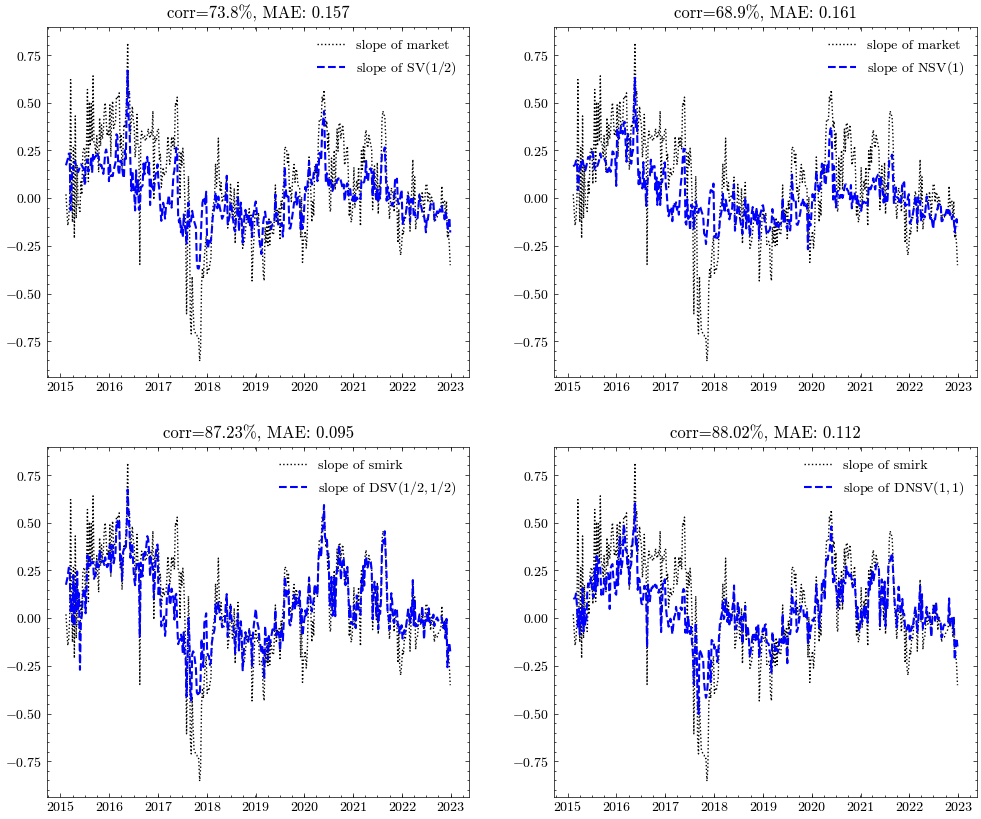

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

x_date = pd.to_datetime(slope.index)

ax[0][0].plot(x_date, slope.values.reshape(-1), label='slope of market',color='black',linestyle='dotted')
ax[0][0].plot(x_date, slope_05.values.reshape(-1), label='slope of SV($1/2$)',color='blue',linestyle='--',linewidth=1.5)
corr = np.round(np.corrcoef(slope.values.reshape(-1), slope_05.values.reshape(-1))[0,1]*100, 2)
mae  = np.round(np.mean(np.abs(slope.values.reshape(-1) - slope_05.values.reshape(-1))), 3)
ax[0][0].set_title('corr='+str(corr)+'%, MAE: '+str(mae))
ax[0][0].legend(framealpha=1)

ax[0][1].plot(x_date, slope.values.reshape(-1), label='slope of market',color='black',linestyle='dotted')
ax[0][1].plot(x_date, slope_10.values.reshape(-1), label='slope of NSV($1$)',color='blue',linestyle='--',linewidth=1.5)
corr = np.round(np.corrcoef(slope.values.reshape(-1), slope_10.values.reshape(-1))[0,1]*100, 2)
mae  = np.round(np.mean(np.abs(slope.values.reshape(-1) - slope_10.values.reshape(-1))), 3)
ax[0][1].set_title('corr='+str(corr)+'%, MAE: '+str(mae))
ax[0][1].legend(framealpha=1)

ax[1][0].plot(x_date, slope.values.reshape(-1), label='slope of smirk', color='black',linestyle='dotted')
ax[1][0].plot(x_date, slope_0505.values.reshape(-1), label='slope of DSV($1/2,1/2$)', color='blue',linestyle='--',linewidth=1.5)
corr = np.round(np.corrcoef(slope.values.reshape(-1), slope_0505.values.reshape(-1))[0,1]*100, 2)
mae  = np.round(np.mean(np.abs(slope.values.reshape(-1) - slope_0505.values.reshape(-1))), 3)
ax[1][0].set_title('corr='+str(corr)+'%, MAE: '+str(mae))
ax[1][0].legend(framealpha=1)

ax[1][1].plot(x_date, slope.values.reshape(-1), label='slope of smirk', color='black',linestyle='dotted')
ax[1][1].plot(x_date, slope_1010.values.reshape(-1), label='slope of DNSV($1,1$)', color='blue',linestyle='--',linewidth=1.5)
corr = np.round(np.corrcoef(slope.values.reshape(-1), slope_1010.values.reshape(-1))[0,1]*100, 2)
mae  = np.round(np.mean(np.abs(slope.values.reshape(-1) - slope_1010.values.reshape(-1))), 3)
ax[1][1].set_title('corr='+str(corr)+'%, MAE: '+str(mae))
ax[1][1].legend(framealpha=1)

plt.savefig('fit_slope.eps',dpi=400)
plt.show()